<a href="https://colab.research.google.com/github/Susanna45/PythonDrivingLicence/blob/main/PythonDrivingLicence_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Crop growth analysys

The project is divided as follows:
- in the first part of the code, a global dataset for crop production will be evaluated to analyse the effect of different tillage approaches on the crop yield.
- in the secon part of the code it will be presented a crop growth model describing the develpment of the structural dry weight of a specific variety of lettuce based on a system of ODE defining the physisolagical relationships among the quantities involved

##PART 1: DIFFERENT TILLAGE APPROACHES

The following analysis uses the global dataset for crop production under conventional tillage and no-tillage systems, which are openly available from Su et al.(2021).

The dataset contains paired yield observations comparing conventional tillage and no-tillage conditions for eight major staple crops
in 50 countries.

A recent global meta-analysis study synthesizing 678 studies across 50 crops with 6005 paired observations concluded that no-tillage reduces crop yield by 5%. The aim is to evaluate if the effect of no-tillage can be positive under
some conditions, using interpretable machine learning.

In [ ]:
!pip install interpret

In [ ]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import math
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from interpret.glassbox import ExplainableBoostingRegressor
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoLarsIC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV


In [ ]:
ds = pd.read_csv('/content/Dataset.csv')
ds.head()

,Yield_CT,Yield_NT,NT_effect,Latitude,Longitude,Crop,Years_NT,Crop_rotation_CT,Crop_rotation_NT,Soil_cover_CT,Soil_cover_NT,Weed_pest_control_CT,Weed_pest_control_NT,P,E,PB,Tave,Tmax,Tmin,ST
0,2567.0,2694.0,Yes,48.28,-105.10,wheat.winter,3,0,0,NaN,NaN,1.0,1.0,395.800000,534.828000,-139.028,5.03333,24.798600,-20.095680,Loam
1,2405.0,2439.0,Yes,48.28,-105.10,wheat.winter,4,0,0,NaN,NaN,1.0,1.0,260.300000,590.273000,-329.973,5.79167,29.191860,-21.602860,Loam
2,2439.0,2788.0,Yes,48.28,-105.10,wheat.winter,5,0,0,NaN,NaN,1.0,1.0,397.300000,555.260000,-157.960,6.86667,29.487280,-16.195720,Loam
3,3005.0,2943.0,No,32.42,-93.64,soybean,3,1,1,0.0,1.0,1.0,1.0,511.900005,546.686888,-34.787,26.16000,35.331630,14.984884,Loam
4,3062.0,2670.0,No,32.42,-93.64,soybean,4,1,1,0.0,1.0,1.0,1.0,475.099997,511.402611,-36.303,24.96000,34.272689,13.003511,Loam


In [ ]:
print('Dataset size:' , ds.shape)

Dataset size: (4403, 20)


coefficiente angolare: 0.8984672637458606


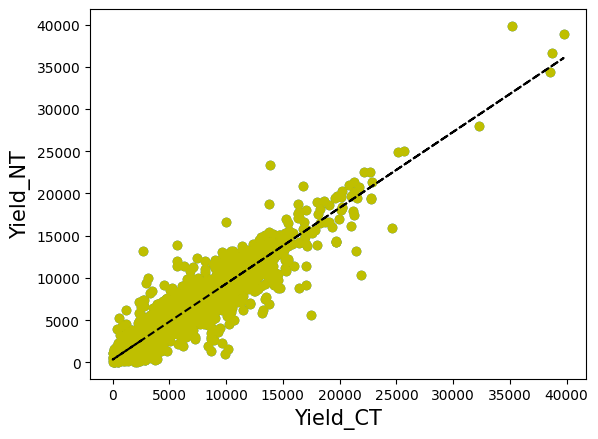

In [ ]:
x=ds['Yield_CT']
y=ds['Yield_NT']
plt.scatter(x, y)
m, b = np.polyfit(x, y, 1)
plt.plot(x, y, 'yo', x, m*x+b, '--k')
plt.xlabel('Yield_CT', fontsize = 15)
plt.ylabel('Yield_NT', fontsize = 15)
print ('coefficiente angolare:', m)

plt.show()

add an extra column to the dataset to analyse the relative yield change:

##$Yield_{change}=\frac{Yield_{NT}-Yield_{CT}}{Yield_{CT}}$

In [ ]:
ds['Yield_change'] = (ds['Yield_NT']-ds['Yield_CT'])/ds['Yield_CT']

In [ ]:
ds.describe(percentiles=[.25,.5,.75,.975])

,Yield_CT,Yield_NT,Latitude,Longitude,Years_NT,Crop_rotation_CT,Crop_rotation_NT,Soil_cover_CT,Soil_cover_NT,Weed_pest_control_CT,Weed_pest_control_NT,P,E,PB,Tave,Tmax,Tmin,Yield_change
count,4403.000000,4403.000000,4403.000000,4403.000000,4403.000000,4403.000000,4403.000000,3791.000000,3791.000000,3822.000000,3822.000000,4403.000000,4403.000000,4403.000000,4403.000000,4403.000000,4403.000000,4403.000000
mean,5255.197602,5056.168160,32.274147,-26.034072,7.801953,0.247558,0.247558,0.041150,0.792667,0.985610,0.984301,520.743084,516.759420,3.983668,18.705704,29.565792,5.642903,0.076113
std,3913.820606,3703.043686,20.578129,80.691005,7.714483,0.431643,0.431643,0.198663,0.405450,0.119109,0.124323,290.137055,115.140738,270.516387,5.682820,4.591855,7.646406,1.920909
min,10.000000,66.000000,-42.630000,-147.870000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-45.300000,229.020000,-741.692000,-1.680000,14.121650,-31.425030,-0.959378
25%,2459.500000,2400.000000,30.900000,-93.750000,2.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,330.600000,440.173000,-176.709000,15.087500,26.678800,1.959840,-0.121531
50%,4150.000000,4015.000000,37.990000,-75.720000,5.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,475.099997,512.061000,-33.867000,18.614286,29.545822,5.119180,-0.025025
75%,7314.500000,7017.000000,43.870000,37.170000,11.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,650.200000,579.474000,112.683000,22.125000,32.457737,9.235000,0.077088
97.5%,14400.000000,13504.750000,53.420000,120.680000,27.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1256.170000,760.064500,733.840000,30.022750,39.587395,20.849976,0.899646
max,39730.000000,39832.000000,64.820000,172.450000,52.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2218.300000,1020.887000,1426.630000,31.780000,41.915010,27.144980,106.000000


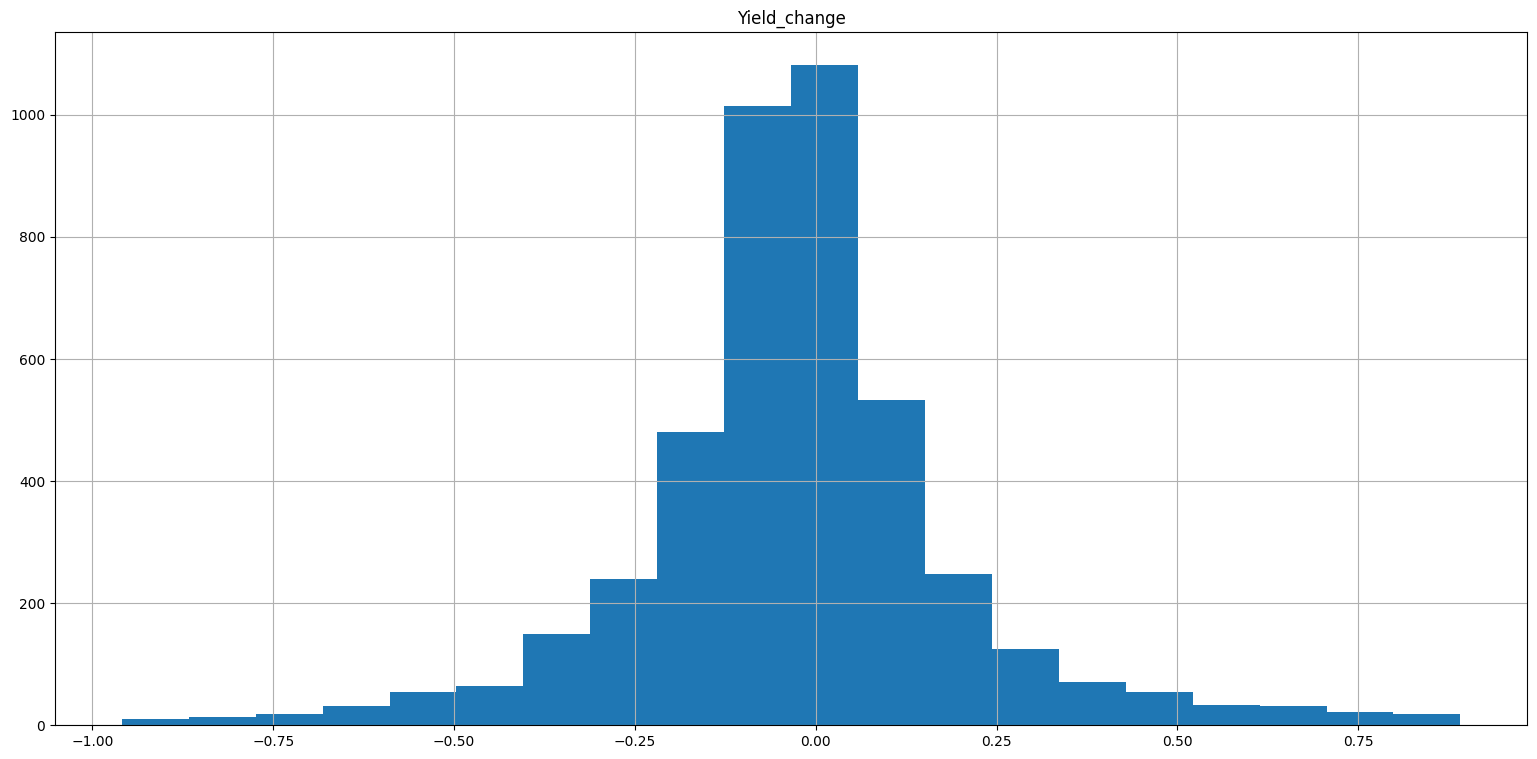

mean =  -0.02703795750718753
standard deviation =  0.22564368905753351


In [ ]:
ds_= ds[ds['Yield_change'] <0.9]
h=ds_.hist(column='Yield_change', bins=20, figsize=(19,9))
plt.show()
print('mean = ', np.mean(np.array(ds_['Yield_change'])))
print('standard deviation = ',np.std(np.array(ds_['Yield_change'])))

plt.show()

The observed relative change in crop yield from conventional
to no-tillage has mean = -0.02, standard deviation
= 0.23  (the extreme values of 97.5th percentile or higher
were removed), indicating that whether no-tillage increases or
decreases crop yield compared to conventional tillage is quite controversial

<Axes: >

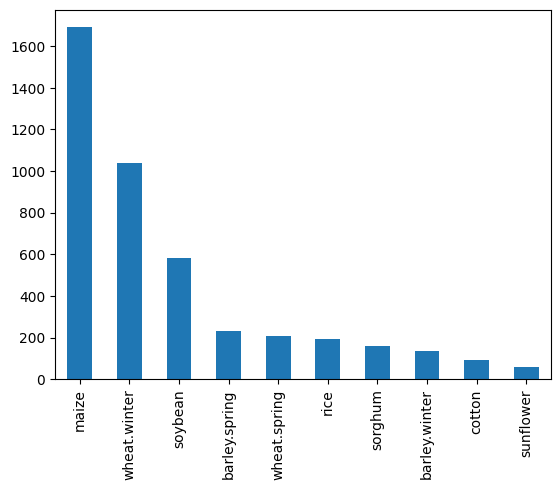

In [ ]:
pd.value_counts(ds['Crop']).plot.bar()

As a case study, we analyze maize, which is  the most dominant crop type in the dataset

In [ ]:
maize_ds = ds[ds['Crop']=='maize'] #select one specific crop

I remove from the dataset the features that are not going to be considered to regress the target variable 'Yield_Change'. Then I remove the any obrervation containing Nan values

In [ ]:
maize_ds = maize_ds.drop([ 'Crop','Yield_NT','NT_effect','Years_NT','Crop_rotation_NT','Weed_pest_control_NT'], axis=1)
maize_ds= maize_ds.dropna()

In [ ]:
maize_ds.shape

(1287, 15)

In [ ]:
column_names = list(maize_ds.columns.values)
print(column_names)

['Yield_CT', 'Latitude', 'Longitude', 'Crop_rotation_CT', 'Soil_cover_CT', 'Soil_cover_NT', 'Weed_pest_control_CT', 'P', 'E', 'PB', 'Tave', 'Tmax', 'Tmin', 'ST', 'Yield_change']


we are going to regress the relative change in Maize crop yield from conventional to no-tillage with 16 variables:
- Crop yield under conventional tillage
as baseline (Yield_CT) [kg/ha];
- latitude and longitude of experimental
sites accounting for spatial dependence [degree];
- crop rotation with at least three crops involved in conventional tillage for temporal dependency (Crop_rotation_CT) [yes/no];
- soil texture (ST) [seven categories related to sand, silt, clay composition];
-  soil cover (Soil_cover_CT and _NT) [yes/no/mixed];
- weed and pest control (Weed_pest_control_CT) [yes/no];
- Precipitation and potential evapotranspiration over the growing season and their difference for water availability (P, E, PB) [mm];
- average, maximum, and minimum air temperature during the growing season
(Tave, Tmax, Tmin, respectively) [degree Celsius]

In [ ]:
maize_ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1287 entries, 39 to 4402
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Yield_CT              1287 non-null   float64
 1   Latitude              1287 non-null   float64
 2   Longitude             1287 non-null   float64
 3   Crop_rotation_CT      1287 non-null   int64  
 4   Soil_cover_CT         1287 non-null   float64
 5   Soil_cover_NT         1287 non-null   float64
 6   Weed_pest_control_CT  1287 non-null   float64
 7   P                     1287 non-null   float64
 8   E                     1287 non-null   float64
 9   PB                    1287 non-null   float64
 10  Tave                  1287 non-null   float64
 11  Tmax                  1287 non-null   float64
 12  Tmin                  1287 non-null   float64
 13  ST                    1287 non-null   object 
 14  Yield_change          1287 non-null   float64
dtypes: float64(13), int6

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

for c in maize_ds.columns:
   if maize_ds[c].dtype=='object':
        lbl = LabelEncoder()
        lbl.fit(list(maize_ds[c].values)) #associa a ogni valore unico (classe) della variabile categorica un valore numerico tra in {0,..,n_classi-1}
        maize_ds[c] = lbl.transform(maize_ds[c].values) #trasforma le variabili categoriche nei valori definiti sopra


In [ ]:
maize_ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1287 entries, 39 to 4402
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Yield_CT              1287 non-null   float64
 1   Latitude              1287 non-null   float64
 2   Longitude             1287 non-null   float64
 3   Crop_rotation_CT      1287 non-null   int64  
 4   Soil_cover_CT         1287 non-null   float64
 5   Soil_cover_NT         1287 non-null   float64
 6   Weed_pest_control_CT  1287 non-null   float64
 7   P                     1287 non-null   float64
 8   E                     1287 non-null   float64
 9   PB                    1287 non-null   float64
 10  Tave                  1287 non-null   float64
 11  Tmax                  1287 non-null   float64
 12  Tmin                  1287 non-null   float64
 13  ST                    1287 non-null   int64  
 14  Yield_change          1287 non-null   float64
dtypes: float64(13), int6

In [ ]:
target = maize_ds['Yield_change']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(maize_ds.drop(['Yield_change'], axis=1), target, train_size=0.80, random_state=42)


In [ ]:
column_names=X_train.columns.values # remove the target column name and keep only the regressors' column names
categorical_features=['Crop_rotation_CT','Soil_cover_CT','Soil_cover_NT','Weed_pest_control_CT', 'ST']
numerical_features = X_train.columns.drop(categorical_features)

['Yield_CT' 'Latitude' 'Longitude' 'Crop_rotation_CT' 'Soil_cover_CT'
 'Soil_cover_NT' 'Weed_pest_control_CT' 'P' 'E' 'PB' 'Tave' 'Tmax' 'Tmin'
 'ST']


In [ ]:
# Define a function that compares the CV perfromance of a set of predetrmined models
def cv_comparison(models, X_, y_, cv):
    # Initiate a DataFrame for the averages and a list for all measures
    cv_accuracies = pd.DataFrame()
    maes = []
    mses = []
    r2s = []
    accs = []
    # Loop through the models, run a CV, add the average scores to the DataFrame and the scores of
    # all CVs to the list
    for model in models:
      mae = -np.round(cross_val_score(model, X_, y_, scoring='neg_mean_absolute_error', cv=cv), 4)
      maes.append(mae)
      mae_avg = round(mae.mean(), 4)
      mse = -np.round(cross_val_score(model, X_, y_, scoring='neg_mean_squared_error', cv=cv), 4)
      mses.append(mse)
      mse_avg = round(mse.mean(), 4)
      r2 = np.round(cross_val_score(model, X_, y_, scoring='r2', cv=cv), 4)
      r2s.append(r2)
      r2_avg = round(r2.mean(), 4)
      acc = np.round((100 - (100 * (mae * len(X_))) / sum(y_)), 4)
      accs.append(acc)
      acc_avg = round(acc.mean(), 4)
      cv_accuracies[str(model)] = [mae_avg, mse_avg, r2_avg, acc_avg]
    cv_accuracies.index = ['Mean Absolute Error', 'Mean Squared Error', 'R^2', 'Accuracy']
    return cv_accuracies, maes, mses, r2s, accs

we will evaluate the following machine learning algorithms:
- linear model with AIC stepwise variable selection,
- random forests
- gradient boosting
- explainable boosting machine

In [ ]:
rf_random = RandomForestRegressor(random_state=42)
lm = make_pipeline(StandardScaler(),LassoLarsIC(criterion="aic", max_iter=10,eps=2.220446049250313*np.power(math.e,(-15))))
ebm = ExplainableBoostingRegressor()
gb_random = GradientBoostingRegressor(random_state=0)


# MODEL PERFORMANCE

In [ ]:
# Put the models in a list to be used for Cross-Validation
models = [rf_random, lm, gb_random, ebm]

# Run the Cross-Validation comparison with the models used in this analysis
results, maes, mses, r2s, accs = cv_comparison(models, X_train, y_train, 5)


In [ ]:
results.columns = ["rf", "lm", "gb", 'ebm']

# Create DataFrame for all R^2s
r2_results = pd.DataFrame(r2s, index=results.columns, columns=['1st Fold', '2nd Fold', '3rd Fold','4th Fold','5th Fold'])

# Add a column for the averages
r2_results['Average'] = np.round(r2_results.mean(axis=1),5)
r2_results.style.set_caption('R2 model performance')
r2_results

,1st Fold,2nd Fold,3rd Fold,4th Fold,5th Fold,Average
rf,0.3864,0.2611,0.3042,0.0870,0.2635,0.26044
lm,0.1586,0.0942,0.1347,0.1479,0.1004,0.12716
gb,0.3059,0.2529,0.2326,0.1506,0.2078,0.22996
ebm,0.2626,0.1035,0.3469,0.2729,0.1935,0.23588


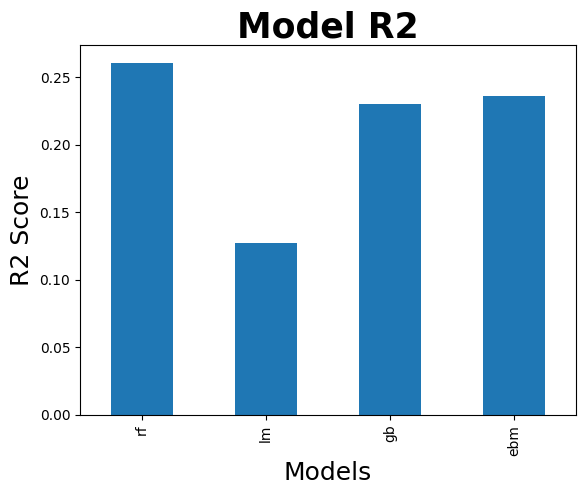

In [ ]:
plt.plot(figsize=(10, 10))
r2_results['Average'].plot.bar()

plt.xlabel("Models", fontsize=18)
plt.ylabel("R2 Score", fontsize=18)

plt.title("Model R2", fontsize=25, fontweight = 'bold')

# Save the figure
plt.savefig('r2.png')
plt.show()

## COMMENT
The model performance revealed random forests as the best algorithm (average R2 = 0.25), followed by explainable boosting machine
(average R2 =0.24),gradient boosting (average R2 =0.20), and linear model (average R2 =0.13)

# PERMUTATION IMPORTANCE without correlated variables

In [ ]:
corr = X_train.corr()
corr.style.background_gradient(cmap='coolwarm')

,Yield_CT,Latitude,Longitude,Crop_rotation_CT,Soil_cover_CT,Soil_cover_NT,Weed_pest_control_CT,P,E,PB,Tave,Tmax,Tmin,ST
Yield_CT,1.000000,0.250298,-0.086710,-0.020419,-0.041039,0.037641,0.047919,-0.214352,-0.211363,-0.126051,-0.202357,-0.066205,-0.200819,-0.132885
Latitude,0.250298,1.000000,-0.340743,-0.053514,0.005932,-0.015938,-0.040855,-0.311774,-0.582133,-0.058513,-0.105288,0.268123,-0.322158,0.090630
Longitude,-0.086710,-0.340743,1.000000,0.082667,0.184129,-0.116410,0.025742,-0.134974,-0.122047,-0.084391,0.341211,0.125511,0.466422,-0.053650
Crop_rotation_CT,-0.020419,-0.053514,0.082667,1.000000,0.026197,0.055009,-0.114743,0.017576,-0.028628,0.031220,0.122798,0.012438,0.156690,-0.126543
Soil_cover_CT,-0.041039,0.005932,0.184129,0.026197,1.000000,0.098345,0.015299,-0.041491,-0.073171,-0.009741,0.235821,0.270620,0.233473,-0.023005
Soil_cover_NT,0.037641,-0.015938,-0.116410,0.055009,0.098345,1.000000,-0.044030,-0.081892,-0.015949,-0.077603,-0.089462,-0.083976,-0.143079,0.069561
Weed_pest_control_CT,0.047919,-0.040855,0.025742,-0.114743,0.015299,-0.044030,1.000000,0.044259,0.007157,0.042606,-0.028767,-0.070694,0.011525,0.016337
P,-0.214352,-0.311774,-0.134974,0.017576,-0.041491,-0.081892,0.044259,1.000000,0.297396,0.900988,0.166604,-0.067219,0.301138,-0.018302
E,-0.211363,-0.582133,-0.122047,-0.028628,-0.073171,-0.015949,0.007157,0.297396,1.000000,-0.146265,-0.023888,-0.161088,0.079312,-0.052500
PB,-0.126051,-0.058513,-0.084391,0.031220,-0.009741,-0.077603,0.042606,0.900988,-0.146265,1.000000,0.183477,0.003552,0.275977,0.004893


In [ ]:
X_train_perm = X_train.drop([ 'PB','Tave' ], axis=1)
column_names_perm = np.array(list(X_train_perm.columns.values))

rf_random.fit(X_train_perm, y_train)
ebm.fit(X_train_perm, y_train)
gb_random.fit(X_train_perm, y_train)
lm.fit(X_train_perm, y_train)

#Compute permutation importance for all the models
perm_importance_rf = permutation_importance(rf_random, X_train_perm, y_train, n_repeats= 30)
perm_importance_lm = permutation_importance(lm, X_train_perm, y_train, n_repeats= 30)
perm_importance_ebm = permutation_importance(ebm, X_train_perm, y_train, n_repeats= 30)
perm_importance_gb = permutation_importance(gb_random, X_train_perm, y_train,n_repeats= 30)

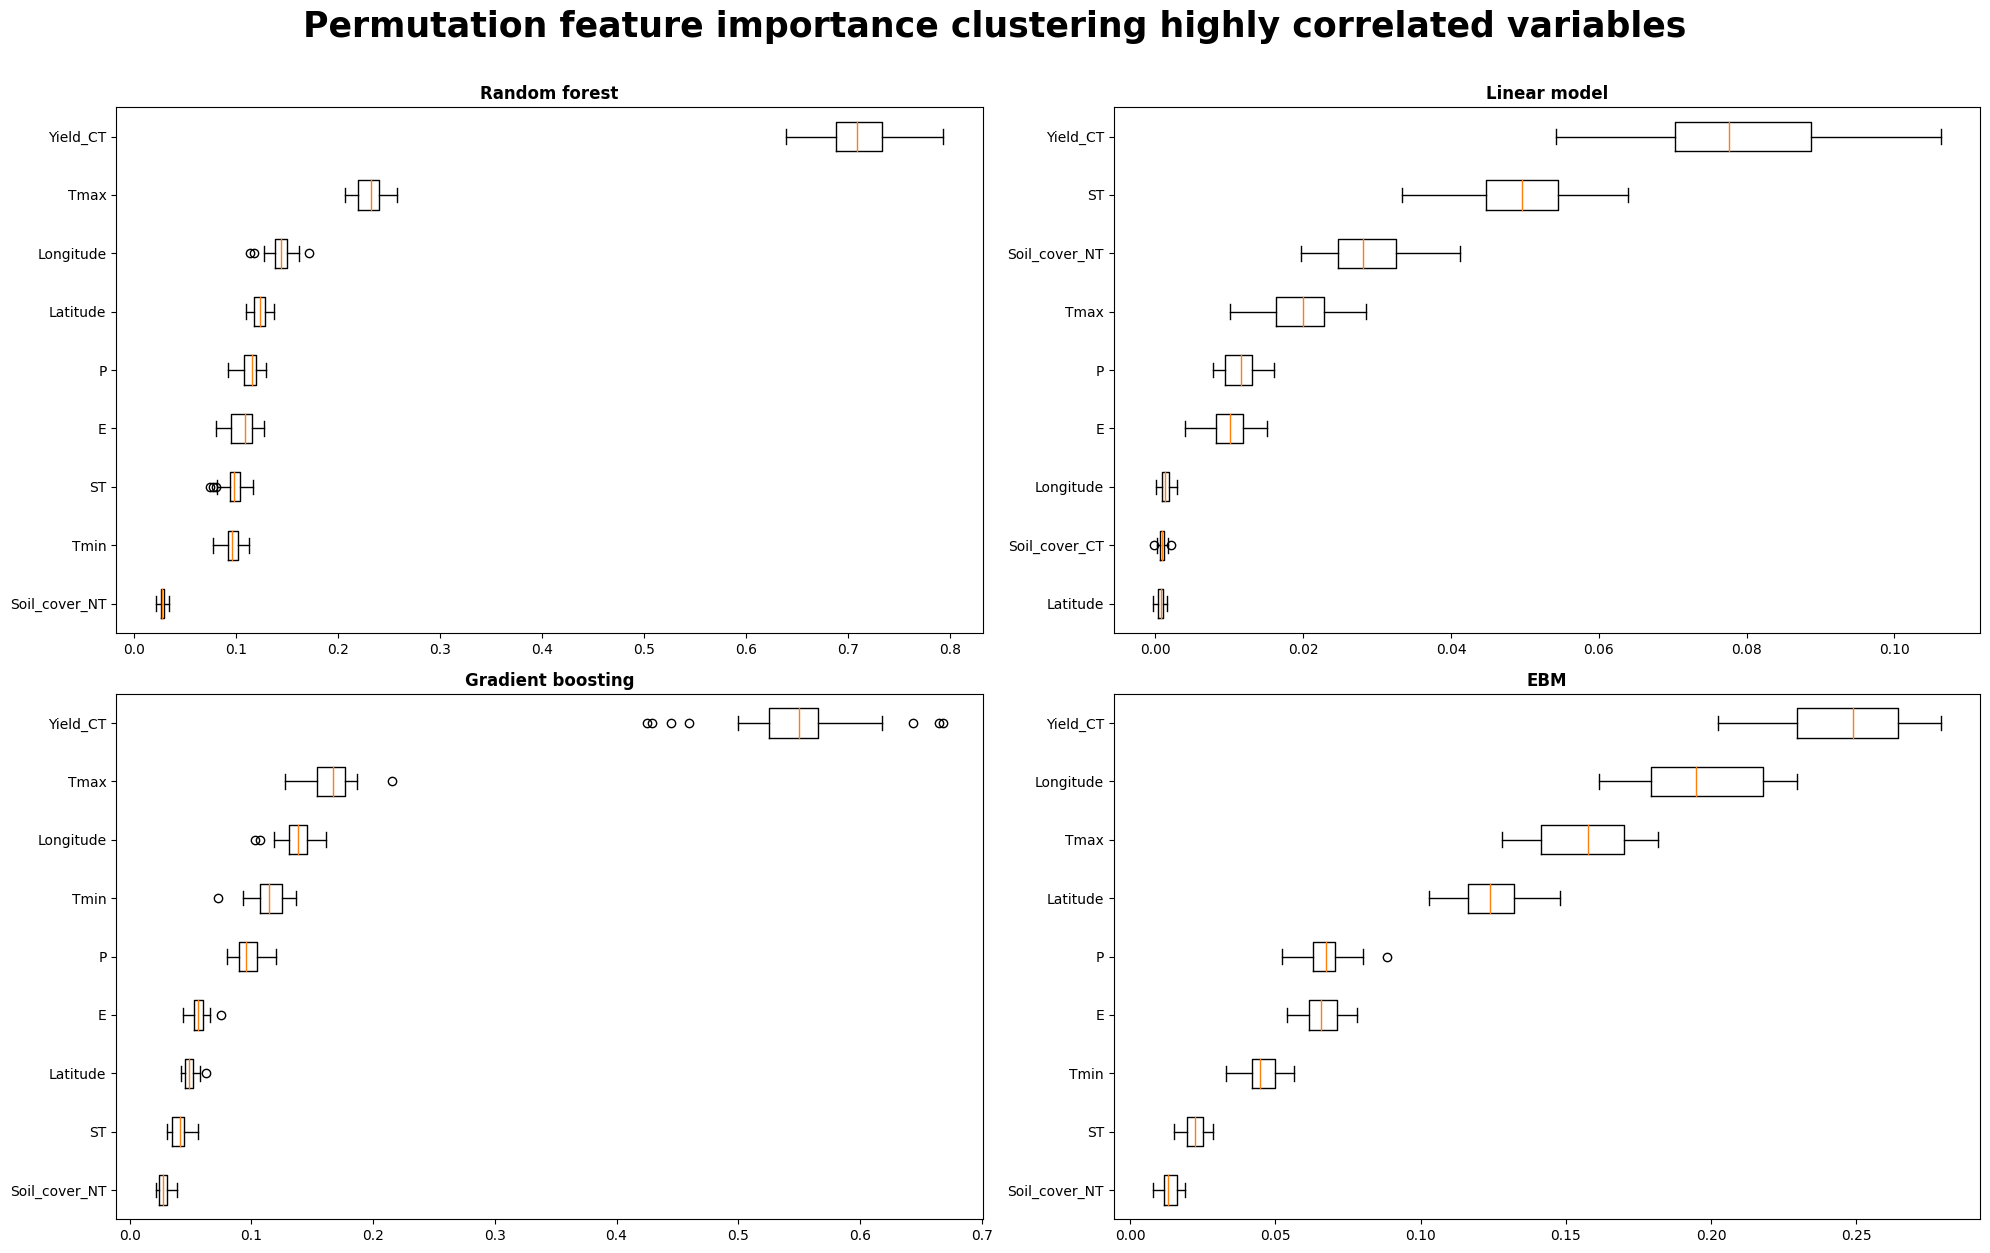

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(20,12))
fig.tight_layout()

sorted_idx = perm_importance_rf.importances_mean.argsort()
sorted_idx10 = sorted_idx[3:13]

ax[0,0].boxplot(
    perm_importance_rf.importances[sorted_idx10].T,
    vert=False,
    labels=column_names_perm[sorted_idx10],
)
ax[0,0].set_title("Random forest", fontweight='bold')

sorted_idx = perm_importance_lm.importances_mean.argsort()
sorted_idx10 = sorted_idx[3:13]

ax[0,1].boxplot(
    perm_importance_lm.importances[sorted_idx10].T,
    vert=False,
    labels=column_names_perm[sorted_idx10],
)
ax[0,1].set_title("Linear model", fontweight='bold')

sorted_idx = perm_importance_gb.importances_mean.argsort()
sorted_idx10 = sorted_idx[3:13]

ax[1,0].boxplot(
    perm_importance_gb.importances[sorted_idx10].T,
    vert=False,
    labels=column_names_perm[sorted_idx10],
)
ax[1,0].set_title("Gradient boosting", fontweight='bold')

sorted_idx = perm_importance_ebm.importances_mean.argsort()
sorted_idx10 = sorted_idx[3:13]

ax[1,1].boxplot(
    perm_importance_ebm.importances[sorted_idx10].T,
    vert=False,
    labels=column_names_perm[sorted_idx10],
)
ax[1,1].set_title("EBM", fontweight='bold')
fig.tight_layout(rect=[0, 0, 1, 0.99])

fig.suptitle("Permutation feature importance clustering highly correlated variables", fontsize=25, fontweight='bold', y=1.04)  # ADDED main title

# Save the figure
plt.savefig('permutation_feature_importance.png')
plt.show()

In terms of variable importance, the random forests, the explainable boosting machine and the gradient boosting commonly selected yield in conventional tillage Longitude and Tmax as the first three  predictors. The linear model also selected yield in conventional tillage as the top predictor but gave more important to soil related variables than the other models.

---



---



# PARTIAL DEPENDENCE PLOTS


In what follows I will compute 1-way partial dependence with the four different machine-learning models considered so far. (as an example I will only consider the method applied to the Random Forest regressor)

We observe that Yield_CT is strongly negatively dependent on Yield_CT and strongly positively dependent on Tmax, while the positive dependence on Latitude in weak.

In [ ]:
rf_random.fit(X_train, y_train)
ebm.fit(X_train, y_train)
gb_random.fit(X_train, y_train)
lm.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lassolarsic',
                 LassoLarsIC(eps=6.792395990147827e-07, max_iter=10))])

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

common_params = {
    "subsample": 50,
    "n_jobs": 2,
    "grid_resolution": 20,
    "random_state": 0,}

features_info = {
    # features of interest
    "features": column_names,
    # type of partial dependence plot
    "kind": "average",
    # information regarding categorical features
    "categorical_features": categorical_features,
}


Computing partial dependence plots for Random Forest Regressor...


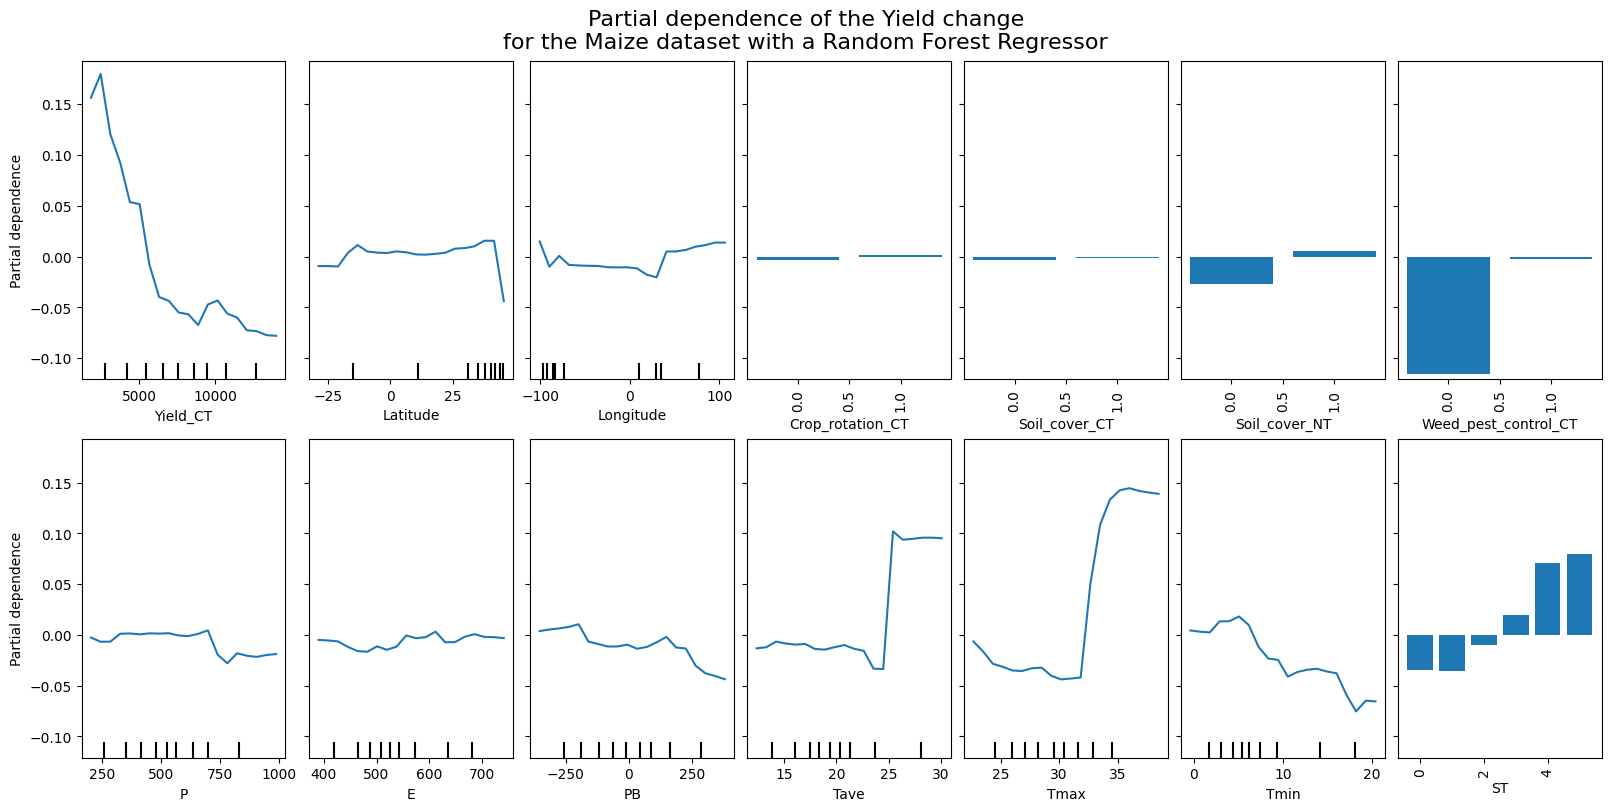

In [ ]:
print("Computing partial dependence plots for Random Forest Regressor...")

_, ax = plt.subplots(ncols=7, nrows=2, figsize=(16, 8), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    rf_random,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)
_ = display.figure_.suptitle(
    "Partial dependence of the Yield change\n"
    "for the Maize dataset with a Random Forest Regressor",
    fontsize=16,
)

I investigate here the effects of Yield_CT, Longitude and Tmax more in details as three out of four models selected these variables within the top 3 in variable importance.

Partial dependence plots are depicted for diagnosing how the associations between Yield_CT and relative yield and between Longitude and relative yield
change were modeled by each of the four algorithms.

The regression model suggests a negative relationship between Yield_Ct and the target variable, while the effect on Tmaz and Longitude on Yield_change is positive

It is possible to identify a minimum of the target variable around longitude = 25and a clear split in the patterns along Tmax around 32°.

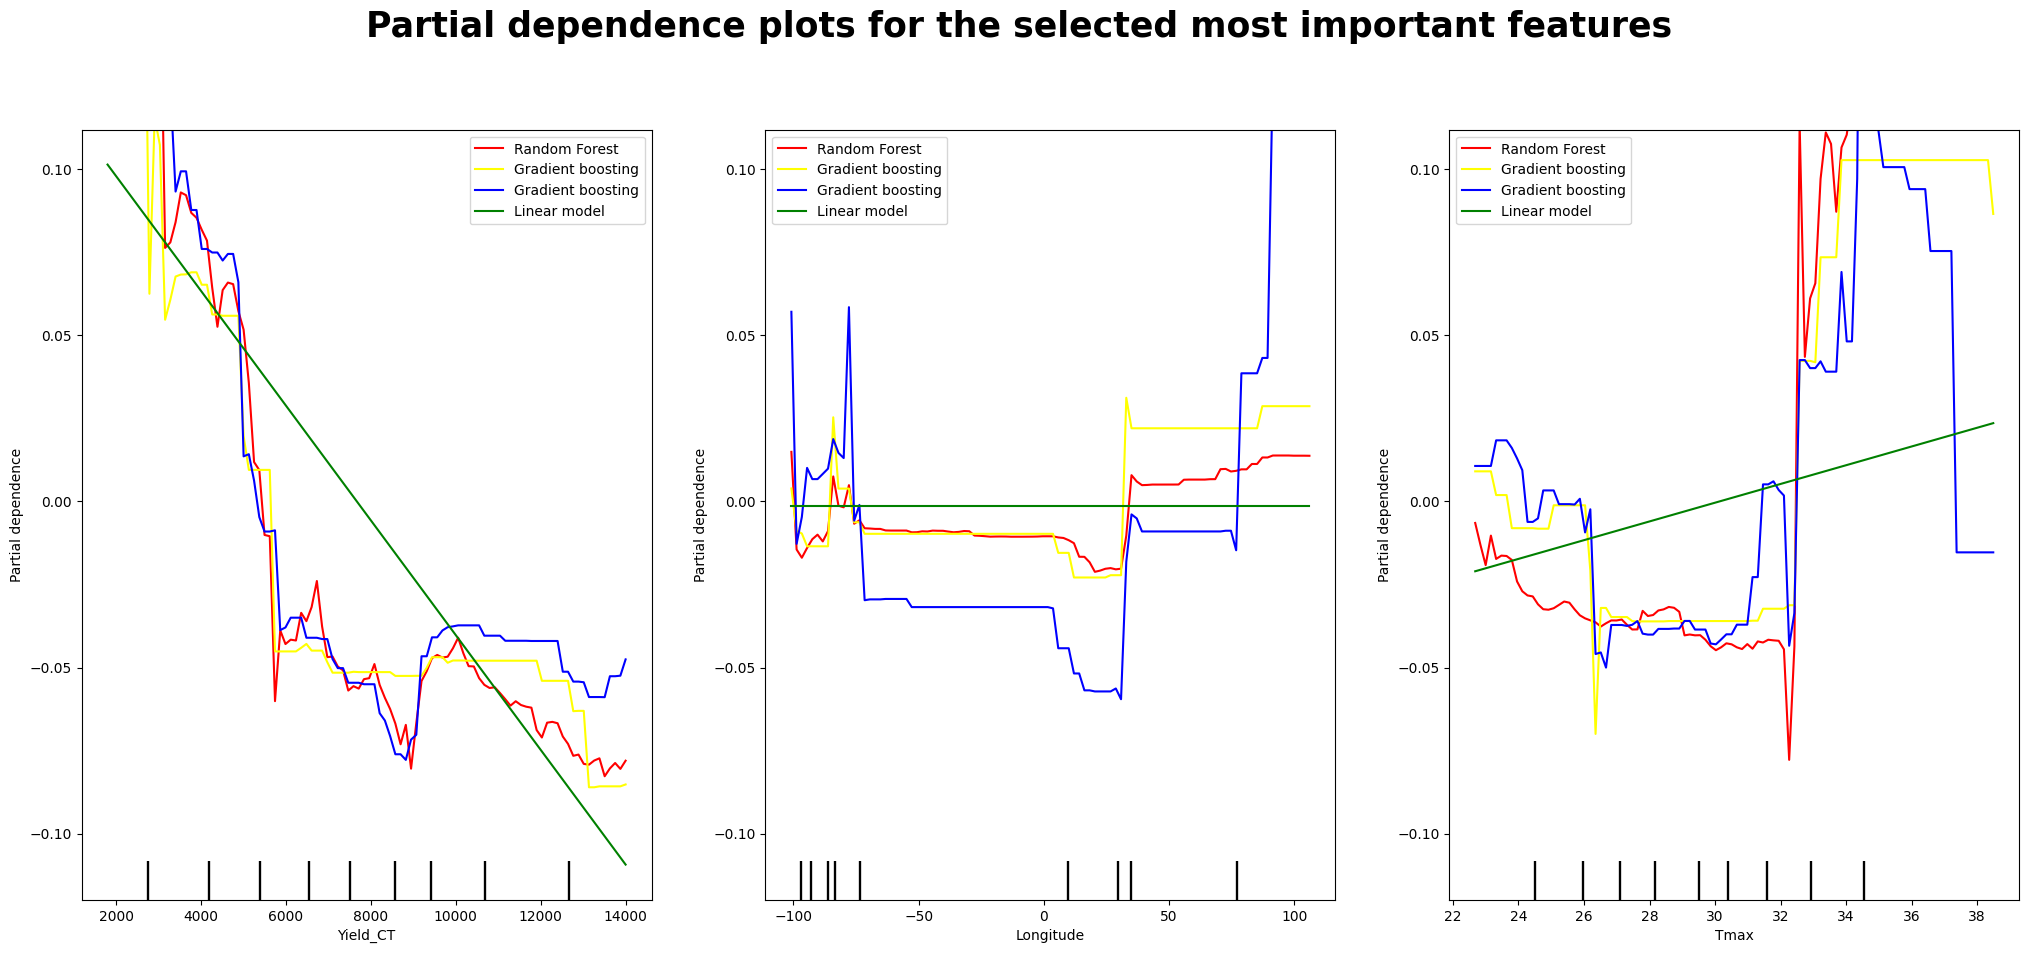

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(25, 10))

rf_disp = PartialDependenceDisplay.from_estimator(rf_random, X_train, ['Yield_CT','Longitude','Tmax'], ax=ax, line_kw={"label": "Random Forest","color": "red"})
gb_disp = PartialDependenceDisplay.from_estimator(gb_random, X_train, ['Yield_CT','Longitude','Tmax'], ax=ax, line_kw={"label":"Gradient boosting","color": "yellow"})
ebm_disp = PartialDependenceDisplay.from_estimator(ebm, X_train, ['Yield_CT','Longitude','Tmax'], ax=ax, line_kw={"label":"Gradient boosting","color": "blue"})
lm_disp = PartialDependenceDisplay.from_estimator(lm, X_train, ['Yield_CT','Longitude','Tmax'], ax=ax, line_kw={"label":"Linear model","color": "green"})

ax[0].legend()

fig.suptitle("Partial dependence plots for the selected most important features\n", fontsize=25, fontweight='bold', y=1.0)  # ADDED main title

plt.show()

To get inisghts and to visually confirm the joint effect of the most important features (Yield_change, Tmax) on the target variable, I plot a 2-dimensional pdp.


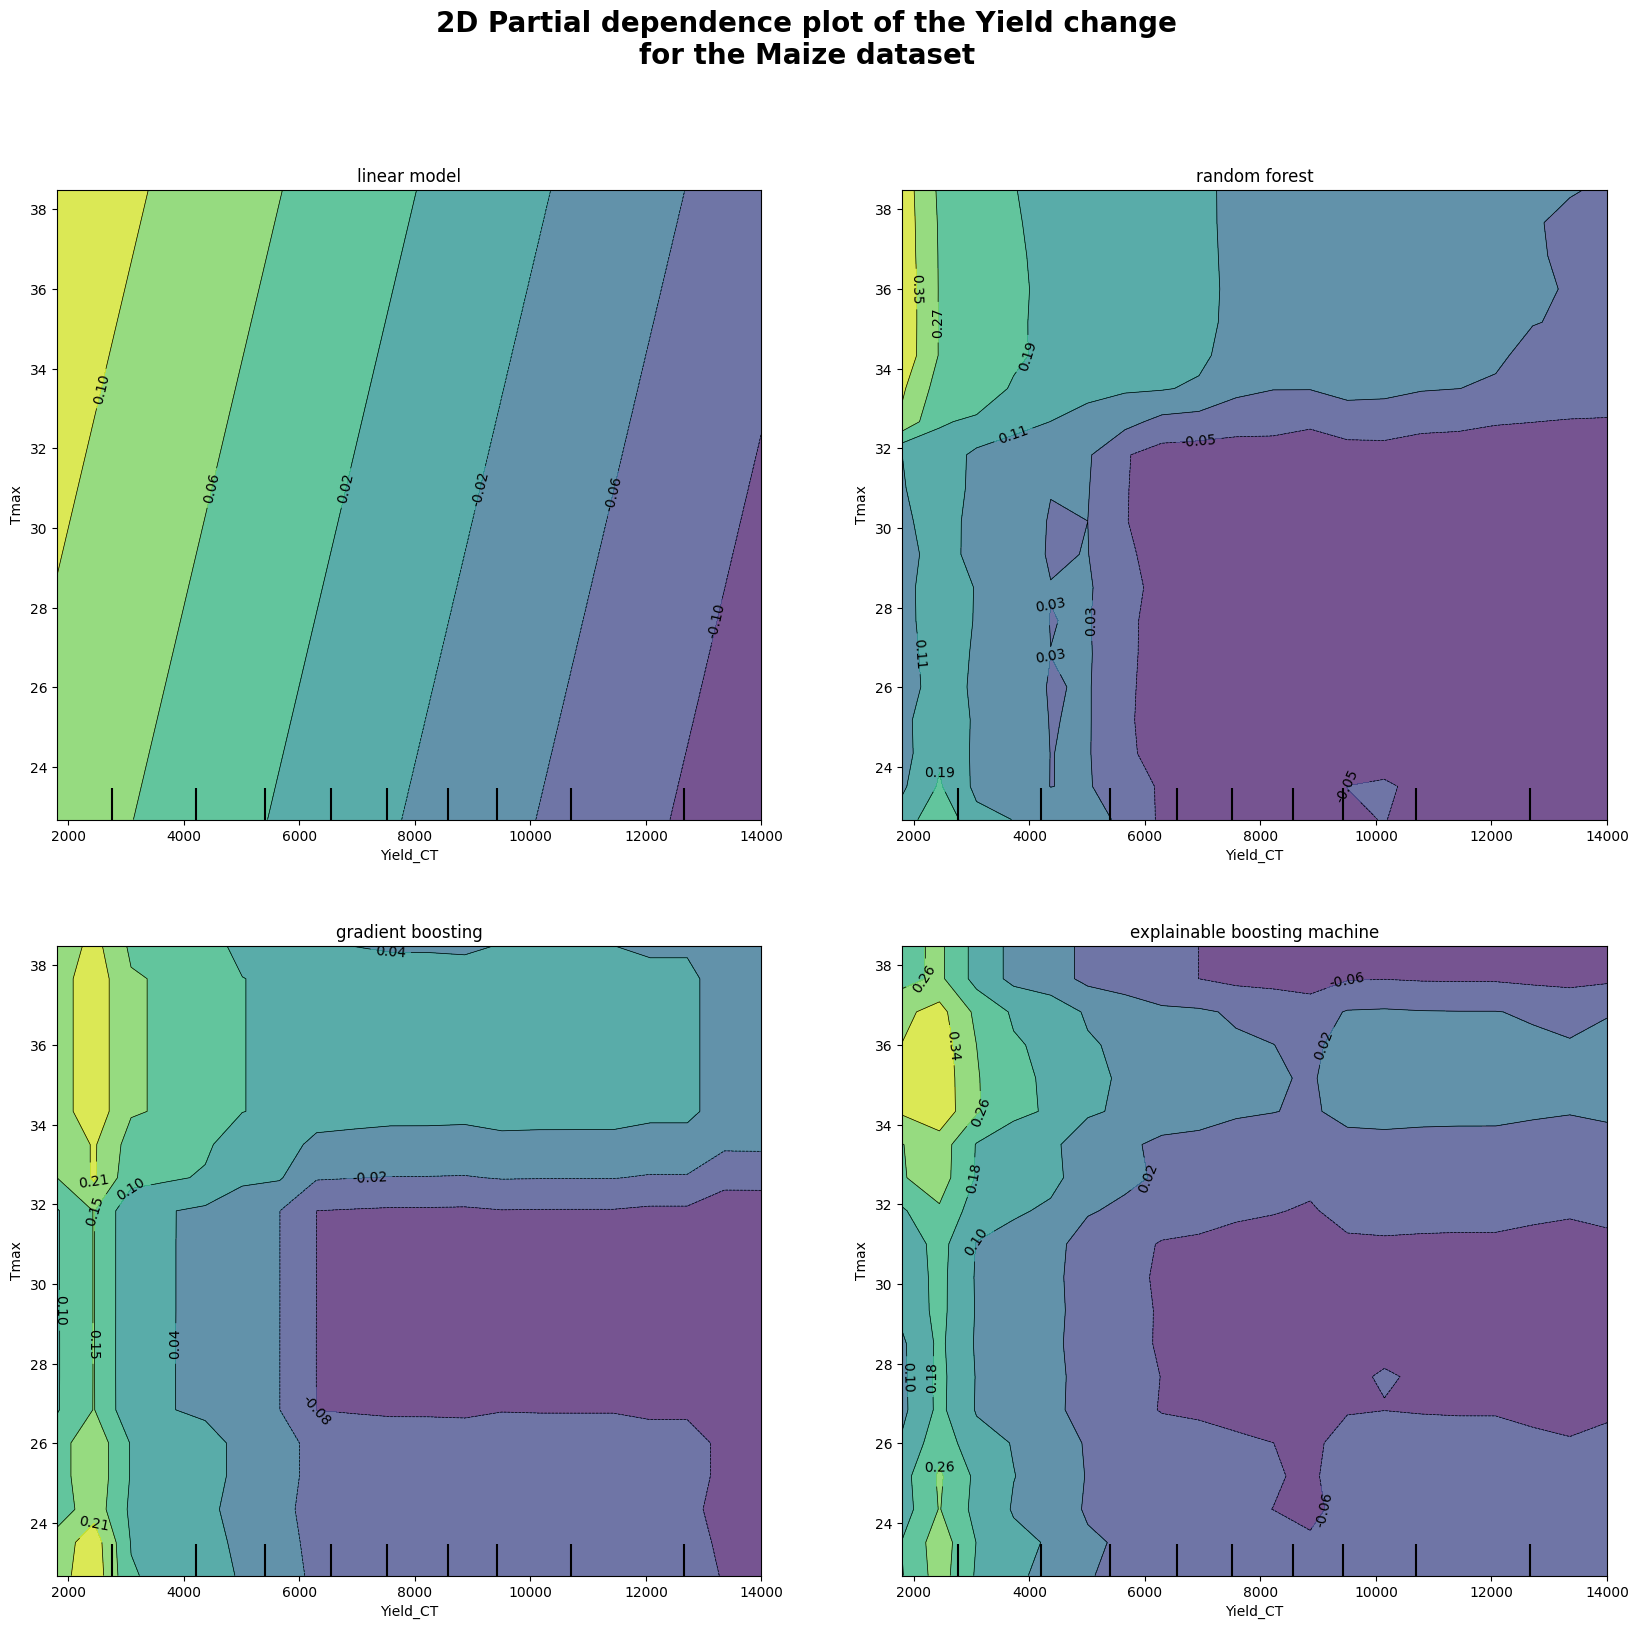

In [ ]:
features_info = {
    # features of interest
    "features": [('Yield_CT','Tmax')],
    # type of partial dependence plot
    "kind": "average",
    # information regarding categorical features
    "categorical_features": categorical_features,
}

fig, ax = plt.subplots(2, 2, figsize=(20,18))


lm_display = PartialDependenceDisplay.from_estimator( lm, X_train, **features_info, ax=ax[0,0],**common_params)
rf_display = PartialDependenceDisplay.from_estimator( rf_random, X_train, **features_info, ax=ax[0,1],**common_params)
gb_display = PartialDependenceDisplay.from_estimator( gb_random, X_train, **features_info, ax=ax[1,0],**common_params)
ebm_display = PartialDependenceDisplay.from_estimator( ebm, X_train, **features_info, ax=ax[1,1],**common_params)

ax[0,0].set_title('linear model')
ax[0,1].set_title('random forest')
ax[1,0].set_title('gradient boosting')
ax[1,1].set_title('explainable boosting machine')

fig.suptitle(
    "2D Partial dependence plot of the Yield change\n"
    "for the Maize dataset",
    fontsize=20, fontweight = 'bold',
)

# Save the figure
plt.savefig('pdp_2D_Tmax.png')
plt.show()


The plots confirm a considerable strong dependence on Tmax when Tmax>32° and a stronger dependence on Yield_CT for this range of temperature (i.e.: for higher temperatures, the negative effect of high values of yield_CT on Yield_CT is weaker)

##PART 2: LETTUCE CROP GROWTH MODEL

Dry weight is a major variable defining the state of the crop. In the model it is assumed that, at a given time, the plant is completely defined by two state variables:
- $X_{NSDW}$ (g $m^{-2}$)= *non-structural dry weight* ( for instance, of glucose, sucrose and starch)
- $X_{SDW}$ (g $m^{-2}$)= *structural dry weight* (the weight of structural components like cell walls and cytoplasm)

such that $X_{DW} = X_{NSDW} + X_{SDW}$ =  Total dry weight

The crop growth model describes the dynamic behaviour of the two
state variables on a square-metre soil basis with the equations:

$\dot{X}_{NSDW}=c_{\alpha}f_{phot}-r_{gr}X_{SDW}-f_{resp}- \frac{1-c_{\beta}}{c_{\beta}}r_{gr}X_{SDW}$

$\dot{X}_{SDW}=r_{gr}X_{SDW}$

the model considers a time range of 60 days and a density of 18 plants per squared meter under the following climatic conditions:


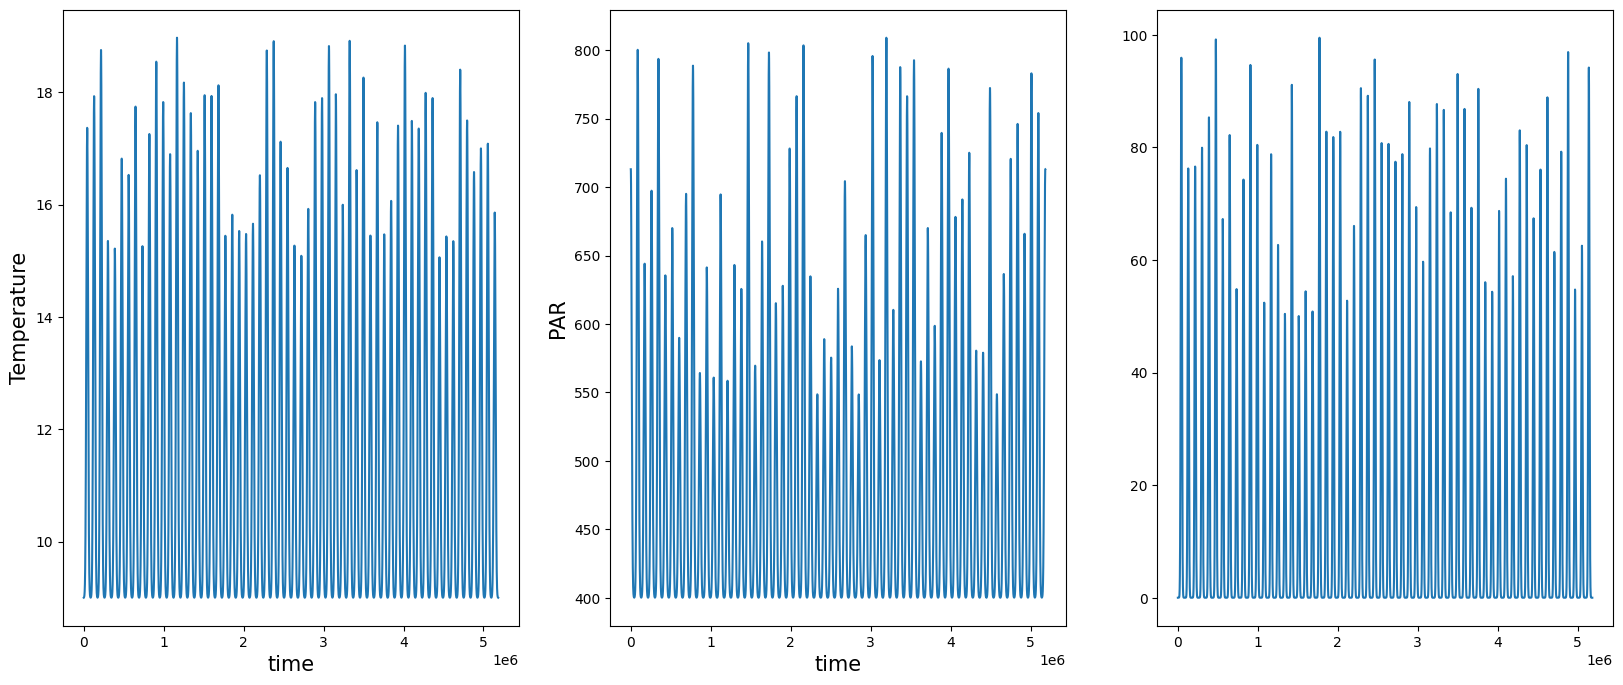

In [31]:
s_day=86400 #seconds per day
ndays=60
step=10

import math
import random

def normpdf(x, mean, sd):
    var = float(sd)**2
    denom = (2*math.pi*var)**.5
    num = np.exp(-(x-mean)**2/(2*var))
    return num/denom

Temp=np.array([])
for i in np.arange(ndays):
  sigma = 0.02
  points=np.linspace(-4*sigma,4*sigma,3600*24)

  curve=normpdf(points,0,sigma)

  curve=curve*random.uniform(0.3, 0.5)
  Temp=np.append(Temp, curve+9)


Co2=np.array([])
for i in np.arange(ndays):
  sigma = 0.00057
  points=np.linspace(-4*sigma,4*sigma,3600*24)

  curve=np.array(normpdf(points,0,sigma))

  curve=curve*random.uniform(0.2, 0.6)
  Co2=np.append(Co2, curve+400)

Co2=np.roll(Co2, -int(86400/2))


Par=np.array([])
for i in np.arange(ndays):
  sigma = 0.004
  points=np.linspace(-6*sigma,6*sigma,3600*24)

  curve=np.array(normpdf(points,0,sigma))

  curve=curve*random.uniform(0.5, 1)
  Par=np.append(Par, curve)

U={
   'T': Temp,
   'CO2':Co2,
   'PAR':Par
}

fig, ax = plt.subplots(1, 3, figsize=(20,8))
ax[0].plot(U['T'])
ax[0].set_xlabel('time', fontsize = 15)
ax[0].set_ylabel('Temperature', fontsize = 15)

ax[1].plot(U['CO2'])
ax[1].set_xlabel('time', fontsize = 15)
ax[1].set_ylabel('CO2', fontsize = 15)

ax[2].plot(U['PAR'])
ax[1].set_xlabel('time', fontsize = 15)
ax[1].set_ylabel('PAR', fontsize = 15)
plt.show()


I define the constants parameters involved in the growth model

In [53]:
c_alpha=0.68
c_beta=0.8
c_lar=75*10**(-3)
#c_k=0.9
c_tau=0.15
c_w=1.83*10**(-3)
c_Gamma=40
c_Q10gamma=2
c_eps=17*10**(-6)
g_bnd=0.007
g_stm=0.005
g_car1= -1.32*10**(-5)
g_car2= 5.94*10**(-4)
g_car3= 2.63*10**(-3)
c_grMax= 5*10**(-6)
c_gamma= 1
c_Q10gr=1.6
c_Q10resp=2
c_respsht=1.16*10**(-7)
c_resprt=3.47*10**(-7)

beta=0.09
c_max=0.9 #maximum etinction coefficient
c_min= 0.3  #minimum etinction coefficient
L_0= 1.2 #critical LAI

I define the system of ODE describing the growth of the structural dry weight of the lettuce crop

In [62]:
from scipy.integrate import odeint
#DATI INIZIALI

d=300 #plant density (plants/m^2)
P_DW_0 =0.000857143 #initial plant dry weight (Bat)
X_DW_0= 0.72
X_NSDW_0=0.25*X_DW_0
X_SDW_0=0.75*X_DW_0

#ODE

def X_DW(y, _t):
    t=min(int(_t),ndays*s_day-1)
    T_t = U['T'][t]
    CO2_t= U['CO2'][t]
    PAR_t = U['PAR'][t]


    X_SDW, X_NSDW  = y

    Gamma_= c_Gamma*c_Q10gamma**((T_t-20)/10)

    eps_=c_eps*(CO2_t-Gamma_)/(CO2_t+2*Gamma_)

    g_car= g_car1*T_t**2+g_car2*T_t+g_car3

    g_CO2=(g_bnd**(-1)+ g_stm**(-1)+g_car**(-1))**(-1)

    f_photMax= (eps_*PAR_t*g_CO2*c_w*( CO2_t- Gamma_))/((eps_*PAR_t)+(g_CO2*c_w*( CO2_t- Gamma_)))

    ct =0 #critical time
    c_k= np.clip(c_max-beta*(c_lar*(1-c_tau)*X_SDW-L_0),c_min,c_max)
    #print('c_k=',c_k)

    f_phot=(1-math.e**(-c_k*c_lar*(1-c_tau)*X_SDW))*f_photMax
    #print('f_phot=',f_phot)
    r_gr=c_grMax*(X_NSDW/(c_gamma*X_SDW+X_NSDW))*c_Q10gr**((T_t-20)/10)
    #print('r_gr='r_gr)
    f_resp= (c_respsht*(1-c_tau)*X_SDW+c_resprt*c_tau*X_SDW)*c_Q10resp**((T_t-25)/10)
    #print('f_resp=',f_resp)

    dydt = [r_gr*X_SDW, c_alpha*f_phot-r_gr*X_SDW-f_resp-((1-c_beta)/c_beta)*r_gr*X_SDW]

    return dydt

time= np.arange(0, ndays*s_day, 10)

sol=odeint(X_DW,[X_SDW_0, X_NSDW_0],time)

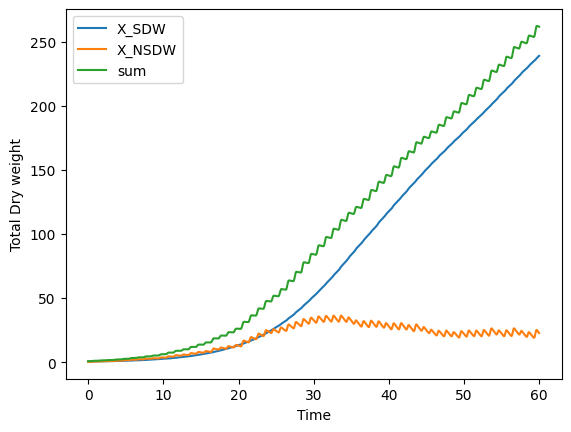

In [55]:
plt.plot(figsize=(15, 6))
plt.plot(time/86400, sol[:,0], label='X_SDW')
plt.plot(time/86400, sol[:,1], label='X_NSDW')
plt.plot(time/86400, sol[:,1]+sol[:,0], label='sum')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Total Dry weight')

plt.show()

In [63]:
LAI=c_lar*(1-c_tau)*sol[:,0]
c_k=np.clip(c_max-beta*(c_lar*(1-c_tau)*sol[:,0]-L_0),c_min,c_max)

critical time = 22.447453703703705 days


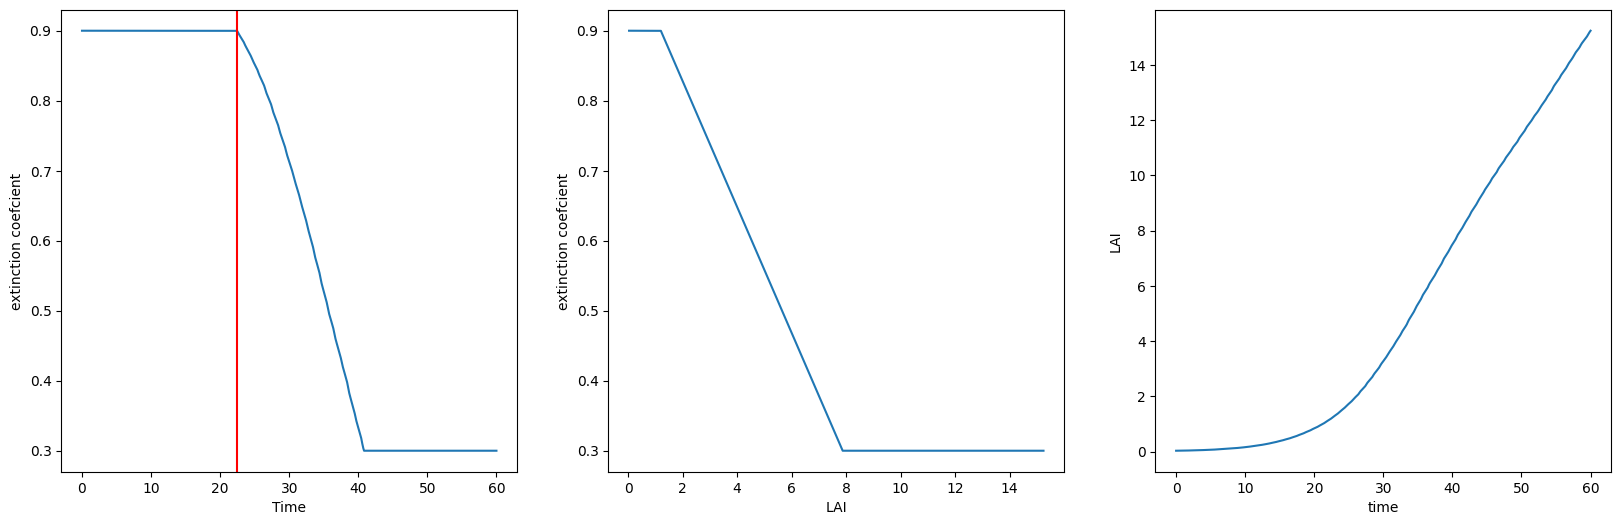

In [64]:
ind= np.argmax(np.where(c_k == c_max))
print('critical time =', time[ind]/86400,'days')

fig, axs = plt.subplots(1, 3, figsize=(20, 6))
axs[0].plot(time/86400, c_k)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('extinction coefcient')
axs[0].axvline(x = time[ind]/86400, color = 'r', label = 'axvline - full height')

axs[1].plot(LAI, c_k)
axs[1].set_xlabel('LAI')
axs[1].set_ylabel('extinction coefcient')

axs[2].plot(time/86400, LAI)
axs[2].set_xlabel('time')
axs[2].set_ylabel('LAI')

plt.show()

In [65]:
ds=np.arange(150, 300 ,10)

In [66]:
ct=np.zeros(ds.shape)
pdw=np.zeros(ds.shape)
dw=np.zeros(ds.shape)

for d in ds:

 X_DW_0=P_DW_0*d
 X_NSDW_0=0.25*X_DW_0
 X_SDW_0=0.75*X_DW_0
 sol=odeint(X_DW,[X_SDW_0, X_NSDW_0],time)
 ct[np.where(ds==d)]=time[np.argmax(np.where(np.clip(c_max-beta*(c_lar*(1-c_tau)*sol[:,0]-L_0),c_min,c_max)  == c_max))]/86400
 pdw[np.where(ds==d)]=(sol[:,1]+sol[:,0])[time.size-1]/d
 dw[np.where(ds==d)]=(sol[:,1]+sol[:,0])[time.size-1]

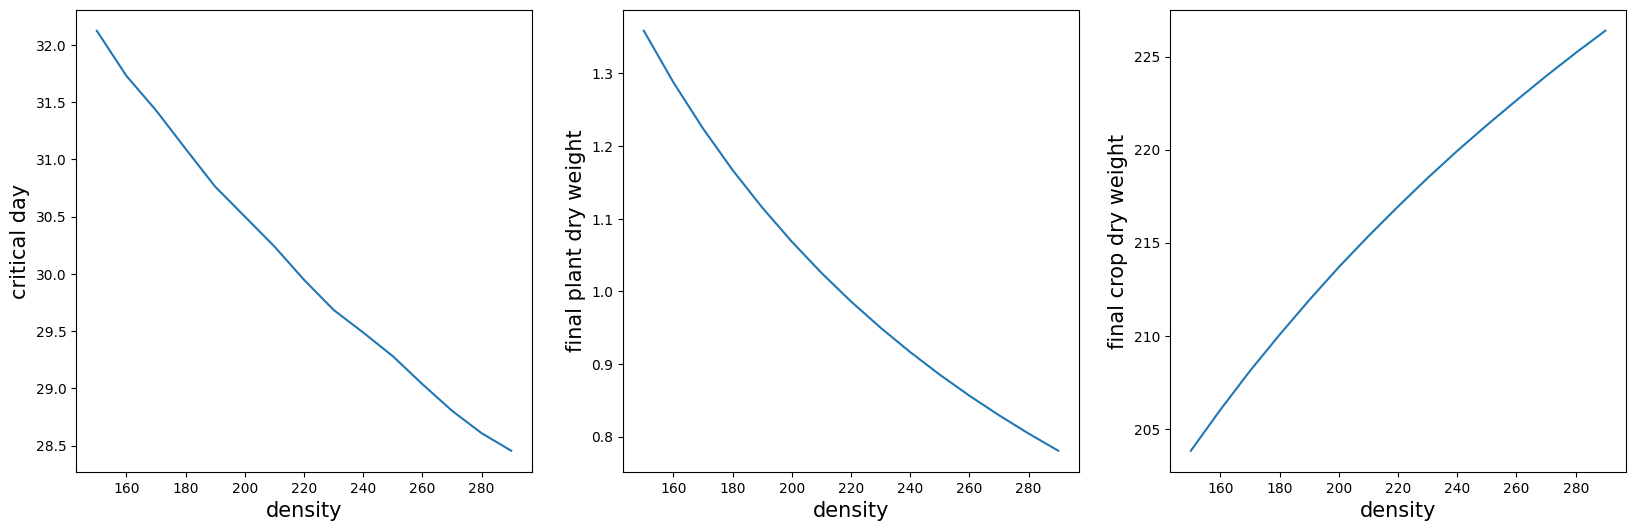

In [67]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].plot(ds, ct)
axs[0].set_xlabel('density', fontsize = 15)
axs[0].set_ylabel('critical day', fontsize = 15)

axs[1].plot(ds, pdw)
axs[1].set_xlabel('density', fontsize = 15)
axs[1].set_ylabel('final plant dry weight', fontsize = 15)

axs[2].plot(ds, dw)
axs[2].set_xlabel('density', fontsize = 15)
axs[2].set_ylabel('final crop dry weight', fontsize = 15)
plt.show()